# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Введение

Нам предстоит изучить датасет с информацией о квартирах, которые были выставлены на продажу в Санкт-Петербурге и Ленинградской области с 2014 по начало 2019 года. Посмотрим на качество исходных  данных: есть ли пропуски, аномалии и дубликаты. Изучим, какие факторы влияют на цену квартиры, какие варианты жилой недвижимости можно считать типичными и какие интересные закономерности можно выявить на основании предложенных данных.

## Загрузка библиотек и исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


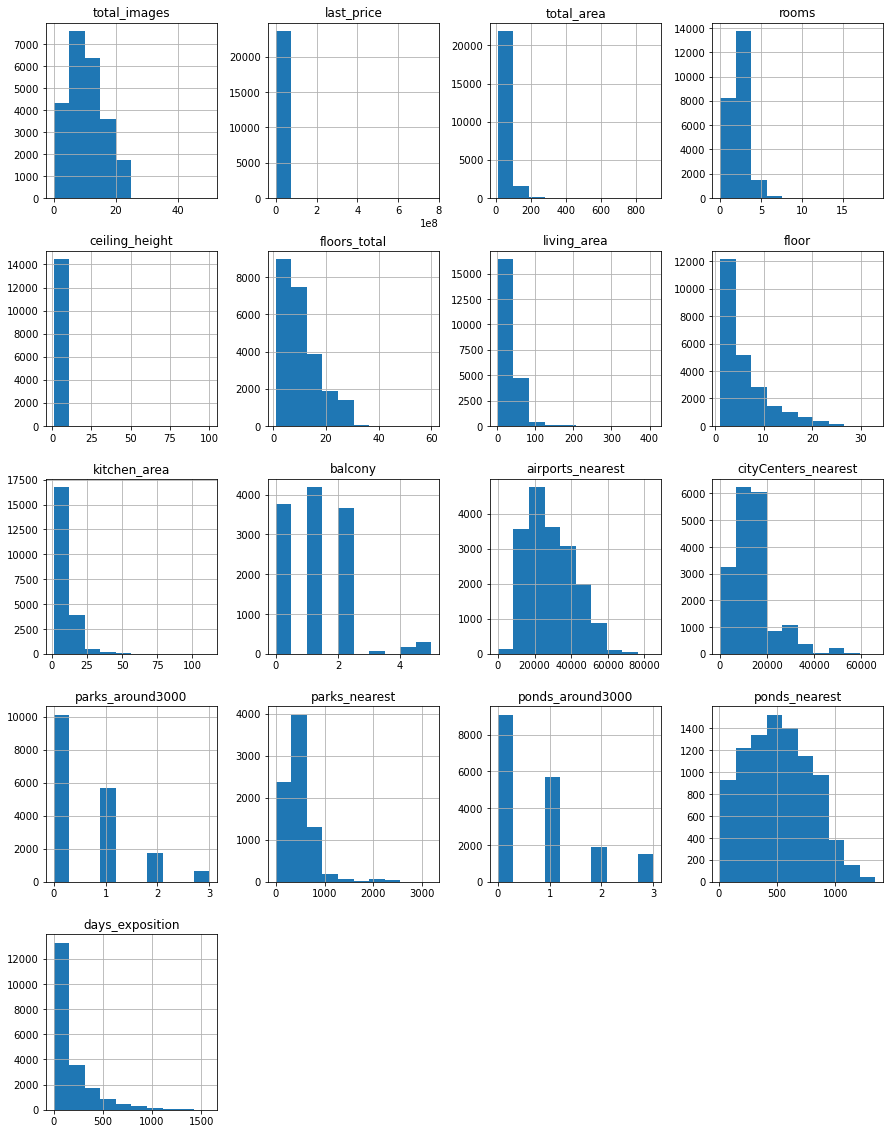

In [5]:
 data_hist = data.hist(figsize=(15, 20))

Просмотрев исходные данные, можно сформулировать задачи по предобработке. Нам предстоит поработать со следующими столбцами:
<br>**last_price**	Проверить на аномалии. Подозрительная минимальная цена
<br>**rooms**	Проверить на аномалии и возможно убрать квартиры с очень большим количеством комнат
<br>**ceiling_height**	Заполнить пустые ячейки медианами и проверить аномалии
<br>**floors_total**	Проверить аномалии и убрать пустые ячейки (заполнить не получится)
<br>**living_area**	Заполнить пустые ячейки и проверить аномалии
<br>**is_apartment** Заполнить пустые значения False и изменить тип данных
<br>**kitchen_area**	Заполнить пустые ячейки и проверить аномалии
<br>**balcony**	Заполнить пустые ячейки нулями
<br>**cityCenters_nearest**	Переименовать
<br>**locality_name** Удалить неявные дубликаты	
**days_exposition** Изменить тип данных

## Предобработка данных

Посмотрим, есть ли в данных полные дубликаты

In [6]:
data.duplicated().sum()

0

Переименуем столбец cityCenters_nearest, чтобы он соответствовал правилам хорошего стиля

In [7]:
data = data.rename(
    columns={
        'cityCenters_nearest' : 'city_centers_nearest'
    }

)

**Заполнение пропусков**
<br>Сначала заполним пропуски в тех столбцах, где отсутствующие значения можно заменить на ноль. Это is_apartment и balcony.

In [8]:
data.is_apartment = data.is_apartment.fillna(False)
data.balcony = data.balcony.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Посмотрим, в каком диапазоне цены в выборке

In [9]:
data.last_price.describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

О максимальной цене судить трудно, но минимальная подозрительно мала. Возможно, кто-то указал цену в валюте.
Посмотрим, какие еще есть низкие цены.

In [10]:
data[data['last_price']<500000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31T00:00:00,2,NaN,1.0,23.0,1,False,...,5.8,0.0,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
6859,6,490000.0,40.0,2017-12-11T00:00:00,1,NaN,5.0,NaN,3,False,...,NaN,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,False,...,40.5,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31T00:00:00,2,NaN,5.0,30.3,3,False,...,5.5,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
10782,3,490000.0,29.1,2016-05-05T00:00:00,1,2.50,5.0,17.0,5,False,...,5.5,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.0
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,False,...,NaN,0.0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000.0,32.0,2019-01-06T00:00:00,1,NaN,2.0,16.0,1,False,...,NaN,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000.0,38.5,2018-07-11T00:00:00,2,2.65,2.0,NaN,1,False,...,NaN,0.0,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,False,...,NaN,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,False,...,6.0,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Остальные данные в пределах нормы. Отсечем строку с ценой 12190

In [11]:
data = data[data['last_price'] != 12190]

Проанализируем столбец rooms. Посмотрим, какие значения есть в столбце

In [12]:
data.rooms.unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12],
      dtype=int64)

Изучим, какие варианты жилья имеют 0 комнат. Часть из них - студии. Это правдоподобно и данные корректны

In [13]:
data_0_rooms = data.query('rooms == 0')
data_0_rooms[data_0_rooms['studio'] == True].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,NaN,24.0,15.50,2,False,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,False,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,NaN,10.0,NaN,7,False,...,NaN,0.0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000.0,24.10,2017-12-01T00:00:00,0,2.75,25.0,17.50,21,False,...,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000.0,17.00,2017-06-07T00:00:00,0,2.70,9.0,12.00,1,False,...,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0


Оставшиеся квартиры имеют свободную планировку.

In [14]:
data_0_rooms[data_0_rooms['studio'] == False]['open_plan'].unique()


array([ True])

Высота потолков ceiling_height указана не для всех вариантов жилья. Возможно, не все продавцы указывают этот параметр при публикации объявления. Заполним отсутствующие данные медианными значениями.

In [15]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Для некоторых данных не указано общее количество этажей. Возможно, люди не заполнили эти поля или данные потерялись из-за технического сбоя. Объем данных небольшой, корректно заполнить их не получится. Можно убрать такие строки из выборки.

In [16]:
data = data[~data['floors_total'].isna()]

Перед тем, как заполнять пропуски в данных о жилой площади и площади кухни, проверим, есть ли квартиры, где сумма этих параметров превышают общую площадь

In [17]:
data['kitchen+lr']=data['kitchen_area']+data['living_area']
data[data['kitchen+lr']>data['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen+lr
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0,32.30
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,...,0.0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0,25.00
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0,39.83
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,...,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0,55.30
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,False,...,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0,46.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,27.00,2.0,38.00,2,False,...,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.60
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,False,...,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0,38.60
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,False,...,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0,94.40
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,False,...,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0,52.00


Посмотрим внимательнее на зничения living_area

In [18]:
data.living_area.describe()

count    21742.000000
mean        34.462894
std         22.037933
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Минимальное значение - 2. Это как-то маловато посмотрим, сколько квартир с жилой площадью меньше 5

In [19]:
data[data['living_area'] < 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen+lr
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,2.65,17.0,3.0,17,False,...,0.0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,14.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,False,...,0.0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0,11.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,2.65,24.0,2.0,22,False,...,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.00,8.0,3.0,8,False,...,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0,19.0


Посмотрим на кухни меньше 3 м

In [20]:
data[data['kitchen_area'] < 3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen+lr
906,15,2600000.0,27.00,2017-07-10T00:00:00,1,2.75,23.0,18.0,18,False,...,0.0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0,20.00
6262,9,3100000.0,24.00,2018-06-25T00:00:00,2,3.00,5.0,16.0,5,False,...,0.0,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0,18.00
7950,3,5967734.0,66.40,2017-02-07T00:00:00,2,2.65,4.0,44.4,2,False,...,0.0,Санкт-Петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0,47.29
8729,9,2200000.0,18.40,2018-08-20T00:00:00,1,2.52,3.0,14.0,3,False,...,0.0,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0,16.40
9138,17,2920000.0,23.29,2018-12-12T00:00:00,1,2.65,3.0,21.0,1,False,...,0.0,Санкт-Петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0,23.00
11033,6,5350000.0,32.00,2016-04-20T00:00:00,1,2.65,14.0,16.0,10,False,...,0.0,Санкт-Петербург,19008.0,3953.0,0.0,NaN,1.0,69.0,210.0,18.00
16367,2,2720000.0,25.70,2017-10-30T00:00:00,1,2.65,19.0,22.6,11,False,...,0.0,Санкт-Петербург,14472.0,13268.0,0.0,NaN,0.0,NaN,109.0,24.60
17834,5,2940000.0,34.70,2017-10-09T00:00:00,1,2.65,26.0,15.5,14,False,...,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,318.0,17.80
19642,5,1190000.0,14.00,2018-07-29T00:00:00,1,2.65,5.0,11.0,1,False,...,0.0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0,13.00
20217,7,4250000.0,28.50,2019-05-01T00:00:00,1,2.80,14.0,19.5,10,False,...,0.0,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN,20.80


Грустно думать, что где-то существуют такие кухни. Для квартир больше 30 кв. м это выглядит как ошибка.

Исправим эти данные вместе с заполнением пустых значений по следующему принципу:
<br> Выведем коэффициент кухни разделив медианный размер кухни на медианную общую площадь
<br> Также поступим с жилой площадью

In [21]:
living_area_mult = data['living_area'].mean()/data['total_area'].mean()
kitchen_area_mult = data['kitchen_area'].mean()/data['total_area'].mean()
display(living_area_mult, kitchen_area_mult)

0.5711581704808281

0.17505750158725575

Заполним пустые и некорректные значения, умножив общую площадь квартиры на соответствующий коэффициент

In [22]:
data = data.fillna(
    {
        'living_area': data['total_area']*living_area_mult,
        'kitchen_area': data['total_area']*kitchen_area_mult
    }
) #Заполним пустые ячейки

In [23]:
#Исправим жилую площадь меньше 5 и кухни меньше 3 в квартирах более 30 кв. м
data.loc[(data['living_area'] < 5),'living_area'] = data['total_area']*living_area_mult
data.loc[(data['kitchen_area'] < 3) & (data['total_area'] > 30) ,'kitchen_area'] = data['total_area']*kitchen_area_mult

In [24]:
data['kitchen+lr']=data['kitchen_area']+data['living_area'] #Пересчитаем значения 'kitchen+lr' с учетом новых данных

In [25]:
#Исправим значения 'kitchen_area' для строк, где общая площадь меньше суммы кухни и жилой площади
data.loc[(data['kitchen+lr'] > data['total_area']), 'kitchen_area'] = data['total_area']*kitchen_area_mult

In [26]:
data['kitchen+lr']=data['kitchen_area']+data['living_area'] #Пересчитаем значения 'kitchen+lr' с учетом новых данных

In [27]:
#Исправим значения 'living_area' для строк, где общая площадь меньше суммы кухни и жилой площади
data.loc[(data['kitchen+lr'] > data['total_area']), 'living_area'] = data['total_area']*living_area_mult

In [28]:
data['kitchen+lr']=data['kitchen_area']+data['living_area'] #Пересчитаем значения 'kitchen+lr' с учетом новых данных

In [29]:
data[['kitchen_area','living_area']].describe().T

,count,mean,std,min,25%,50%,75%,max
kitchen_area,23612.0,10.477939,6.001800,1.3,7.0,9.0,12.0,112.0
living_area,23612.0,34.550981,22.312479,5.0,19.0,30.0,42.1,409.7


Теперь проверим, есть ли квартиры, где сумма жилой площади и кухни превышают общую площадь

In [30]:
data[data['kitchen+lr']>data['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen+lr


Вспомогательный столбец kitchen+lr больше не нужен, удалим его

In [31]:
data = data.drop('kitchen+lr', axis=1)

Посмотрим, можно ли заполнить отсутствующие данные в столбце locality_name. Возможно, информация о расстоянии до центра города есть только у квартир в Санкт-Петербурге.

In [32]:
data_city = data.query('locality_name != "Санкт-Петербург"')
data_city_no_null = data_city[~data_city['locality_name'].isna()]
data_city_array = data_city_no_null['city_centers_nearest'].unique()
display(np.sort(data_city_array))

array([17012., 17017., 17231., ..., 65952., 65968.,    nan])

Мы видим, что информаци о расстоянии до центра города есть не только в СПб, но цифры начинаются с 17 км. Для строк, где расстояние до центра меньше 15 км можно указать СПб, остальные значения отсечь.

In [33]:
data.loc[(data['city_centers_nearest'] < 15000) & (data['locality_name'].isna()), 'locality_name'] = 'Санкт-Петербург'
data = data[~data['locality_name'].isna()]

Откорректируем данные высоты потолков. Высоту потолков от 20 до 33, скорее всего нужно разделить на 10 для получения корректного значения. Остальные значения меньше 2 и больше 6 м исправить не получится, отсечем их.

In [34]:
ceiling_for_correction = data.query('ceiling_height >= 20 & ceiling_height < 33')
ceiling_for_correction = ceiling_for_correction['ceiling_height']

for row in ceiling_for_correction:
    data.loc[(data['ceiling_height'] == row), 'ceiling_height'] = row/10

In [35]:
data = data[(data['ceiling_height'] > 2) & (data['ceiling_height'] < 6)]

Изменим тип данных в столбцах first_day_exposition, чтобы сделать дату более читаемой и is_apartment, поскольку это логическое значение.

In [36]:
DATA_FORMAT = '%Y-%m-%dT%H:%M:%S'
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format=DATA_FORMAT)
data['is_apartment'] = data['is_apartment'].astype(bool)

Избавимся от неявных дубликотов в столбце locality_name. В нашем случе дубликаты связаны с разным написанием типа населенных пунктов. Для текущего исследования не важен тип населенного пункта (поселок это или деревня), также нет возможности проверить корректность указанных типов. Лучше всего убрать информацию о типе нас. пункта, оставив лишь названия.

In [37]:
to_replace = {
     r'(\b)посёлок (\b)':r'\1\2',
     r'(\b)поселок (\b)':r'\1\2',
    r'(\b)деревня (\b)':r'\1\2',
    r'(\b)городского типа (\b)':r'\1\2',
    r'(\b)садовое товарищество (\b)':r'\1\2',
    r'(\b)село (\b)':r'\1\2',
    r'(\b)городской (\b)':r'\1\2',
    r'(\b)садоводческое некоммерческое товарищество (\b)':r'\1\2',
    r'(\b)коттеджный (\b)':r'\1\2',
    r'(\b)при железнодорожной станции (\b)':r'\1\2',
    r'(\b)станции (\b)':r'\1\2'
}
data['locality_name'] = data['locality_name'].replace(to_replace, regex=True)

un_name = data['locality_name'].unique()

display(np.sort(un_name))

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жилгородок', 'Жилпосёлок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара'

Посмотрим внимательнее на количество комнат в квартирах и распределение общей площади

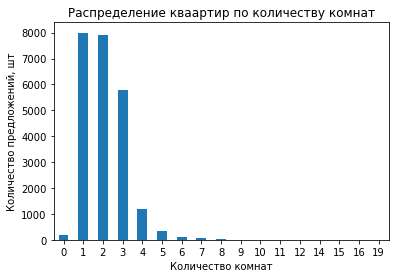

In [38]:
ax = data.groupby('rooms')['floor'].count().plot.bar(title='Распределение кваартир по количеству комнат', rot=0)
ax.set(xlabel='Количество комнат', ylabel='Количество предложений, шт')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

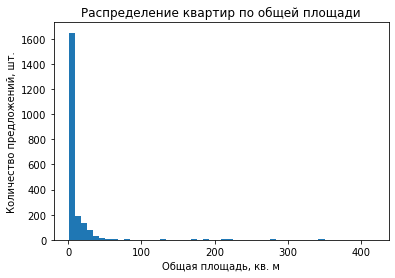

In [39]:
ax = data.groupby('total_area')['floor'].count().plot(kind='hist', bins=50, title='Распределение квартир по общей площади')
ax.set(xlabel='Общая площадь, кв. м', ylabel='Количество предложений, шт.')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Квартир, где больше 6 комнат значительно меньше, чем остальных. Эти данные либо внесены по ошибке, либо являются уникальными предложениями, и их неправильно оценивать по общим критериям (если мне нужна квартира, в которой 10 комнат, как сильно на решение о выборе повлияет размер кухни или наличие рядом парка?), поэтому значения больше 6 лучше отсечь. По тем же причинам уберем из выборки квартиры с общей площадью более 200 м.

Также на гистограмме видно много квартир небольшой площади. Посмотрим на очень маленькие квартиры внимательнее.

In [40]:
data.query('total_area < 20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
716,5,1500000.0,17.00,2017-06-07,0,2.70,9.0,12.000000,1,False,...,2.975978,0.0,Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
4542,12,3300000.0,18.00,2018-11-07,1,3.50,5.0,9.000000,2,False,...,3.151035,0.0,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0
5855,3,945750.0,19.50,2017-09-18,0,2.76,3.0,12.700000,2,False,...,3.413621,0.0,Дубровка,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6084,6,770000.0,18.00,2017-10-16,1,2.65,5.0,13.000000,4,False,...,3.000000,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,90.0
8454,7,2250000.0,19.00,2019-03-12,0,3.00,6.0,10.852005,2,False,...,3.326093,0.0,Санкт-Петербург,12430.0,7316.0,1.0,238.0,3.0,374.0,44.0
8729,9,2200000.0,18.40,2018-08-20,1,2.52,3.0,14.000000,3,False,...,2.400000,0.0,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0
8755,1,1350000.0,18.80,2017-11-22,0,2.75,19.0,10.737774,1,False,...,3.291081,0.0,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,128.0
8886,10,2450000.0,15.50,2018-08-22,0,2.65,5.0,10.000000,2,False,...,2.713391,0.0,Санкт-Петербург,24326.0,4589.0,0.0,NaN,1.0,446.0,27.0
9157,0,3400000.0,17.60,2018-03-18,1,2.65,5.0,10.052384,2,False,...,3.081012,0.0,Санкт-Петербург,21555.0,1967.0,2.0,336.0,1.0,309.0,117.0
9412,5,2100000.0,16.00,2017-12-10,0,2.65,6.0,13.000000,1,False,...,2.800920,0.0,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3.0


Вероятно, это комнаты в коммунальных квартирах или аномалии. Уберем их из выборки, поскольку нас интересуют только продажи целых квартир

In [41]:
data = data[(data['rooms'] < 6) & (data['total_area'] < 200) & (data['total_area'] > 20)]

Изучим варианты, где общее количество этажей более 35. Подозрение вызывают дома в 60 этажей в Кронштадте и 52 этажа в СПб. Скорее всего, это ошибка при вводе или технический сбой. Уберем эти строки.

In [42]:
data[data['floors_total']>35]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000.0,54.0,2018-03-22,2,2.65,36.0,21.4,28,False,...,18.7,1.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,False,...,7.4,0.0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
5807,17,8150000.0,80.0,2019-01-09,2,2.70,36.0,41.0,13,False,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
11079,16,9200000.0,75.0,2019-02-22,2,2.70,36.0,40.0,29,False,...,12.0,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52.0,10.5,18,False,...,14.0,0.0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


In [43]:
data = data[data['floors_total']<50]

В полях, указывающих близость к аэропорту, центру города, паркам и прудам много пропусков. Не считаю целесообразным удалять эти значения, так как в этом случае мы потеряем значительное количество данных. Если понадобится аналитика на основании этих параметрах, мы проведем ее на усеченных данных, а для других исследований будем использовать полную базу.

Также есть пропуски в столбце days_exposition. Вероятнее всего, квартиры, которые не были проданы на момент выгрузки данных. Считаю правильным оставить пропуски в этом столбце.

Посмотрим, как изменился датафрейм в результате предобработки:

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23217 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23217 non-null  int64         
 1   last_price            23217 non-null  float64       
 2   total_area            23217 non-null  float64       
 3   first_day_exposition  23217 non-null  datetime64[ns]
 4   rooms                 23217 non-null  int64         
 5   ceiling_height        23217 non-null  float64       
 6   floors_total          23217 non-null  float64       
 7   living_area           23217 non-null  float64       
 8   floor                 23217 non-null  int64         
 9   is_apartment          23217 non-null  bool          
 10  studio                23217 non-null  bool          
 11  open_plan             23217 non-null  bool          
 12  kitchen_area          23217 non-null  float64       
 13  balcony         

In [45]:
display(f'Мы потеряли {((23699-len(data.total_images))/23699):.2%} данных')

'Мы потеряли 2.03% данных'

В результате предобработки было потеряно чуть больше, чем 2% данных. Зато теперь данные пригодны для анализа и меньше вероятность прийти к неверному выводу.

### Добавление вспомогательных столбцов

Добавим несколько расчетных столбцов для того, чтобы сделать более детальный анализ нескольких факторов.
Рассчитаем цену квадратного метра, выведем отдельно день недели, месяц и год публикации объявления о продаже квартиры, разделим этажи на типы и переведем расстояние до центра города в километры.

In [46]:
data['one_m_price'] = (data['last_price']/data['total_area'])

In [47]:
data['weekday_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

In [48]:
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [49]:
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [50]:
def floor_type(floor):
    if floor['floor'] == 1:
        return 'Первый'
    if floor['floor'] == floor['floors_total']:
        return 'Последний'
    return 'Другой'

data['floor_type'] = data[['floor','floors_total']].apply(floor_type, axis=1)

In [51]:
data['city_centers_nearest_km'] = (data['city_centers_nearest']/1000).round()

In [52]:
data[['last_price','total_area','one_m_price','first_day_exposition','weekday_exposition','month_exposition','year_exposition','floor','floors_total','floor_type','city_centers_nearest','city_centers_nearest_km']].head()

,last_price,total_area,one_m_price,first_day_exposition,weekday_exposition,month_exposition,year_exposition,floor,floors_total,floor_type,city_centers_nearest,city_centers_nearest_km
0,13000000.0,108.0,120370.370370,2019-03-07,3,3,2019,8,16.0,Другой,16028.0,16.0
1,3350000.0,40.4,82920.792079,2018-12-04,1,12,2018,1,11.0,Первый,18603.0,19.0
2,5196000.0,56.0,92785.714286,2015-08-20,3,8,2015,4,5.0,Другой,13933.0,14.0
3,64900000.0,159.0,408176.100629,2015-07-24,4,7,2015,9,14.0,Другой,6800.0,7.0
4,10000000.0,100.0,100000.000000,2018-06-19,1,6,2018,13,14.0,Другой,8098.0,8.0


Добавленные столбцы помогут нам в следующем разделе исследования. Теперь мы сможем подробнее изучить вилияние на цену квартиры таких факторов, как площадь, дата публикации, этаж и расстояние до центра города.

## Исследовательский анализ данных

Взглянем на данные подробнее

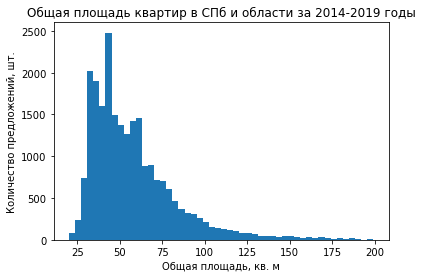

In [53]:
ax = (data['total_area']
      .sort_values()
      .plot(kind='hist', bins=50, title='Общая площадь квартир в СПб и области за 2014-2019 годы')
      .set(xlabel='Общая площадь, кв. м', ylabel='Количество предложений, шт.')
     )

Больше всего предложений на квартиры в районе 45 кв. м. Видимо, это однушки в новостройках. Второй пик приходится на 60-65 кв. м. Это размер стандартной двушки.

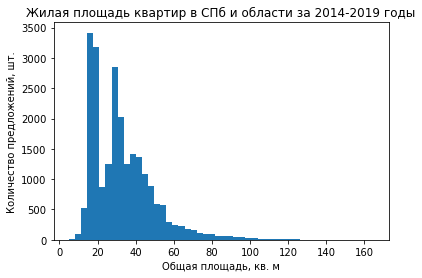

In [54]:
ax = (data['living_area']
      .sort_values()
      .plot(kind='hist', bins=50, title='Жилая площадь квартир в СПб и области за 2014-2019 годы')
      .set(xlabel='Общая площадь, кв. м', ylabel='Количество предложений, шт.')
     )

Больше всего квартир с жилой площадью 15-19 кв. м и около 35 кв. м. Это Однокомнатные и двухкомнатные квартиры. В старых квартирах кухни поменьше, а жилая площадь приближается к новым. Поэтому такой большой пик у площади однушек.

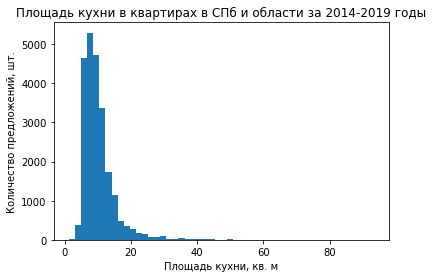

In [55]:
ax = (data['kitchen_area']
      .sort_values()
      .plot(kind='hist', bins=50, title='Площадь кухни в квартирах в СПб и области за 2014-2019 годы')
      .set(xlabel='Площадь кухни, кв. м', ylabel='Количество предложений, шт.')
     )

Больше всего предложений - в районе 10 кв. м. Стандарт типичной новостройки. А вот больше 20 квадратов надо еще поискать.

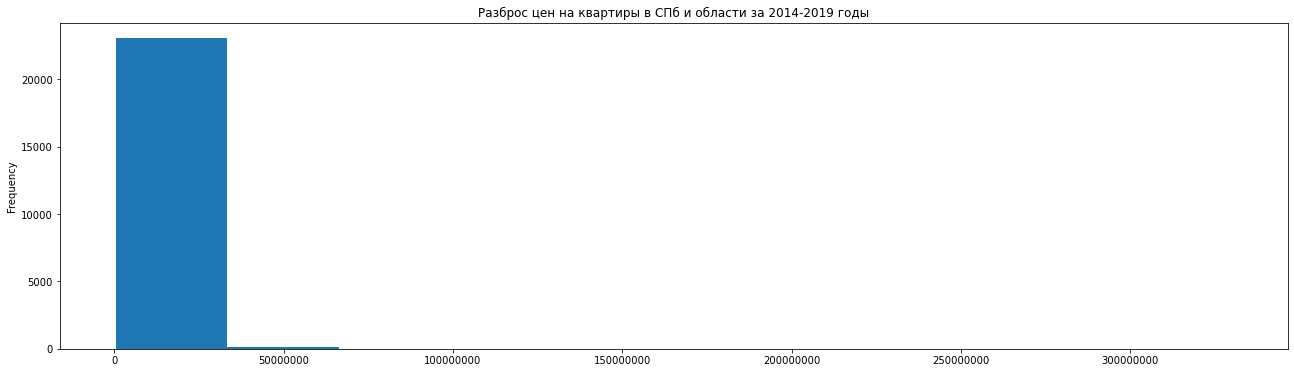

In [56]:
ax = data['last_price'].plot(
    kind='hist',
    title='Разброс цен на квартиры в СПб и области за 2014-2019 годы',
    xlabel='Цена, руб.', 
    ylabel='Количество предложений',
    figsize=(22,6)
    )
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Из-за большого разброса цен график получается неинформативным. Рассмотрим подробнее предложения дешевле 80 млн. руб.

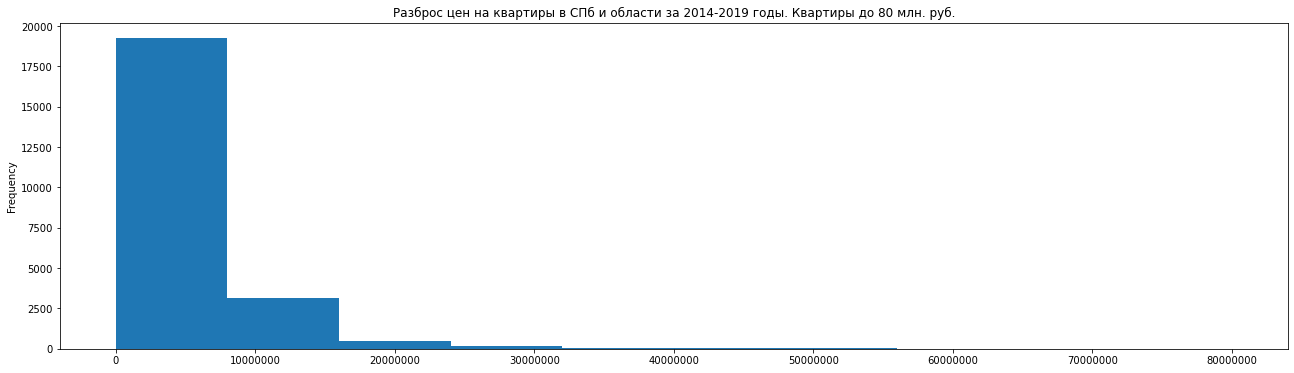

In [57]:
ax = data['last_price'].plot(
    kind='hist',
    title='Разброс цен на квартиры в СПб и области за 2014-2019 годы. Квартиры до 80 млн. руб.',
    xlabel='Цена, руб.', 
    ylabel='Количество предложений',
    figsize=(22,6),
    range=(0,80000000)
    )
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Теперь видно, что основная часть предложений в ценовом диапазоне до 8 млн. руб.

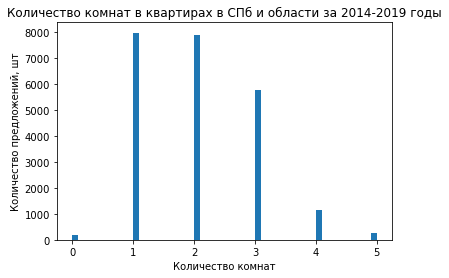

In [58]:
ax = (data['rooms']
      .sort_values()
      .plot(kind='hist', bins=50, title='Количество комнат в квартирах в СПб и области за 2014-2019 годы')
      .set(xlabel='Количество комнат', ylabel='Количество предложений, шт')
     )

Больше всего предложений на 1- и 2-комнатные квартиры. Они и самые востребованные у людей, которые хотят купить жилье.

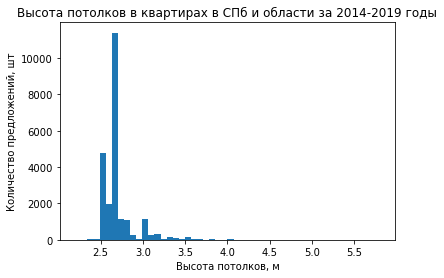

In [59]:
ax = (data['ceiling_height']
      .sort_values()
      .plot(kind='hist', bins=50, title='Высота потолков в квартирах в СПб и области за 2014-2019 годы')
      .set(xlabel='Высота потолков, м', ylabel='Количество предложений, шт')
     )

Самый большой пик в районе 2.65.

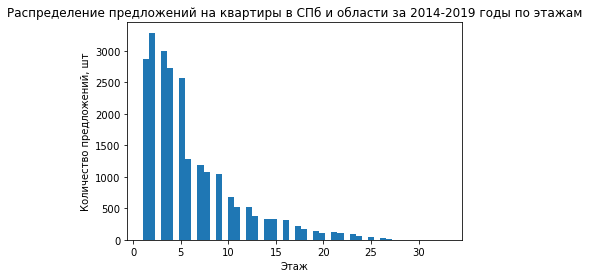

In [60]:
ax = (data['floor']
      .sort_values()
      .plot(kind='hist', bins=50, title='Распределение предложений на квартиры в СПб и области за 2014-2019 годы по этажам')
      .set(xlabel='Этаж', ylabel='Количество предложений, шт')
     )

Больше всего предложений на этажах с первого по пятый. Неудивительно, ведь больше всего в выборке пятиэтажных домов (см. следующий график). Чем выше этаж, тем меньше предложений. 

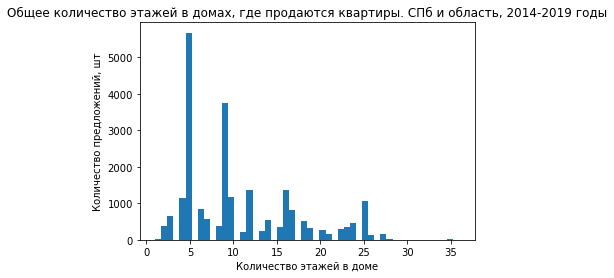

In [61]:
ax = (data['floors_total']
      .sort_values()
      .plot(kind='hist', bins=50, title='Общее количество этажей в домах, где продаются квартиры. СПб и область, 2014-2019 годы')
      .set(xlabel='Количество этажей в доме', ylabel='Количество предложений, шт')
     )

Больше всего пятиэтажек, второй пик - 9 этажей. Интересно посмотреть на аналогичную выборку через 10 лет.

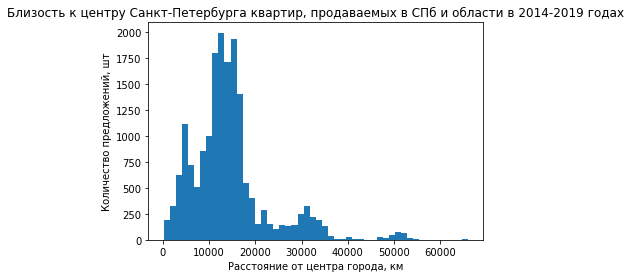

In [62]:
ax = (data['city_centers_nearest']
      .sort_values()
      .plot(kind='hist', bins=50, title='Близость к центру Санкт-Петербурга квартир, продаваемых в СПб и области в 2014-2019 годах')
      .set(xlabel='Расстояние от центра города, км', ylabel='Количество предложений, шт')
     )

Больше всего предложений в районее 12-17 км от центра. Это спальные районы с большой застройкой.

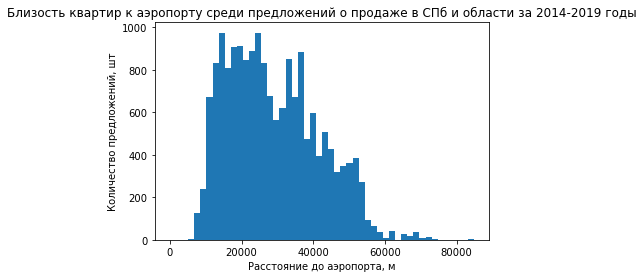

In [63]:
ax = (data['airports_nearest']
      .sort_values()
      .plot(kind='hist', bins=50, title='Близость квартир к аэропорту среди предложений о продаже в СПб и области за 2014-2019 годы')
      .set(xlabel='Расстояние до аэропорта, м', ylabel='Количество предложений, шт')
     )

Абсолютное большинство квартир находится дальше 10 км от аэропорта. Значительная часть - в районе 20 км.

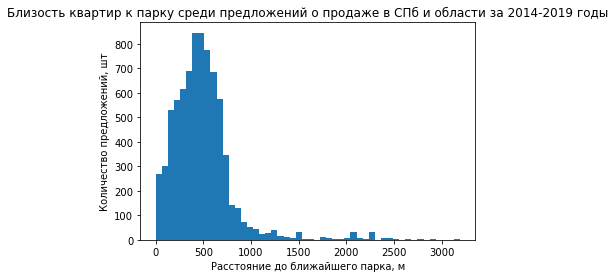

In [64]:
ax = (data['parks_nearest']
      .sort_values()
      .plot(kind='hist', bins=50, title='Близость квартир к парку среди предложений о продаже в СПб и области за 2014-2019 годы')
      .set(xlabel='Расстояние до ближайшего парка, м', ylabel='Количество предложений, шт')
     )

Квартиры, у которых заполнено это поле, чаще всего находятся в 500 м от парка. Совсем неплохо.

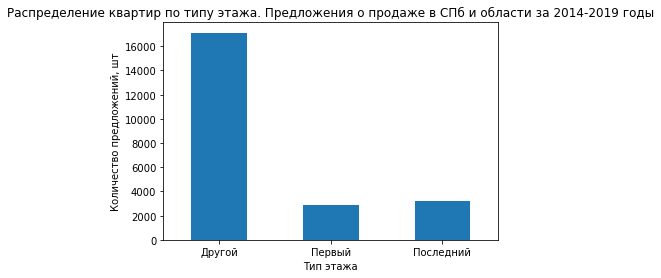

In [65]:
ax = data.groupby('floor_type')['floor'].count().plot.bar(title='Распределение квартир по типу этажа. Предложения о продаже в СПб и области за 2014-2019 годы', rot=0)
ax.set(xlabel='Тип этажа', ylabel='Количество предложений, шт')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

На последнем этаже предложений чуть больше, чем на первом. Неудивительно, ведь на первом этаже часто располагаются нежилые помещения. Больше всего квартир продажится на "прочих" этажах (не первый и не последний), ведь таких этажей больше всего. 

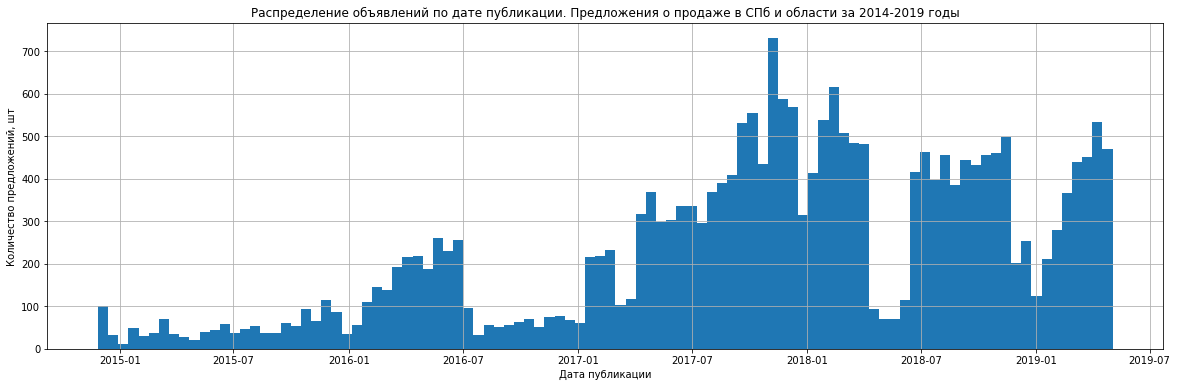

In [66]:
ax = data['first_day_exposition'].hist(bins=100, figsize=(20,6))
ax = ax.set(
    xlabel='Дата публикации', 
    ylabel='Количество предложений, шт', 
    title='Распределение объявлений по дате публикации. Предложения о продаже в СПб и области за 2014-2019 годы'
)

Больше всего объявлений было опубликовано осенью 2018. После этого наблюдаются спады весной 2018 и зимой 2019.

Посмотрим, как долго продавались квартиры из выборки

In [67]:
data.days_exposition.describe()

count    20131.00000
mean       179.63057
std        218.22152
min          1.00000
25%         45.00000
50%         95.00000
75%        230.00000
max       1580.00000
Name: days_exposition, dtype: float64

Есть варианты, которые продались за 1 день, есть квартиры, которые "висят" по 4 года. Медианное значение - 180 дней или полгода.

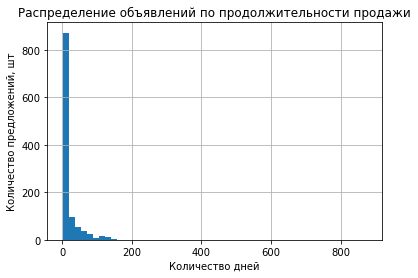

In [68]:
ax = data.groupby('days_exposition')['floor'].count().hist(bins=50)
ax.set(
    xlabel='Количество дней', 
    ylabel='Количество предложений, шт', 
    title='Распределение объявлений по продолжительности продажи')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Более 200 дней продаются единичные кваартиры. Рассмотрим подробнее квартиры, проданные быстрее, чем за 100 дней.

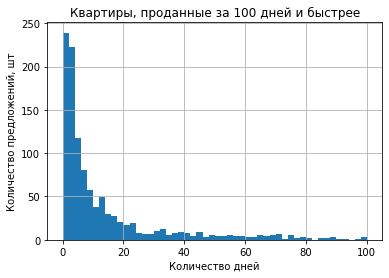

In [69]:
ax = data.groupby('days_exposition')['floor'].count().hist(bins=50, range=(0,100))
ax.set(
    xlabel='Количество дней', 
    ylabel='Количество предложений, шт', 
    title='Квартиры, проданные за 100 дней и быстрее')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

На графике видно, что много квартир продается быстрее, чем за 10 дней. Если человек хочет продать быстро, ставит цену пониже и квартира уходит быстро. Если хотят продать подороже, приходится ждать, иногда долго. Быстрой можно считать продажу менее чем за 45 дней, долгой - более 230.

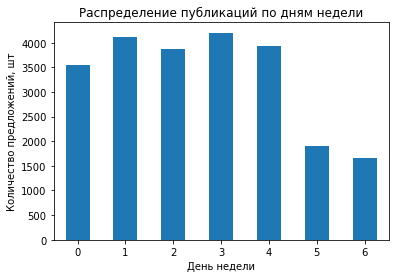

In [70]:
data_weekday = data.pivot_table(index='weekday_exposition', values='floor', aggfunc='count').reset_index()


data_weekday = data_weekday.rename(
    columns={
        'floor' : 'Кол-во объявлений',
        'weekday_exposition': 'День недели'
    }
)
ax = data_weekday.plot(
    x='День недели', 
    y='Кол-во объявлений', 
    kind='bar', 
    title='Распределение публикаций по дням недели', 
    rot=0, legend=False
)
ax = ax.set(ylabel='Количество предложений, шт')

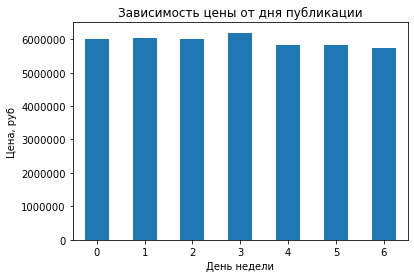

In [71]:
data_weekday_price = data.pivot_table(index='weekday_exposition', values='last_price', aggfunc='mean').reset_index()

ax = data_weekday_price.plot(
    x='weekday_exposition', 
    y='last_price', 
    kind='bar', 
    title='Зависимость цены от дня публикации',
    xlabel='День недели',
    ylabel='Цена, руб',
    legend=False,
    rot=0)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Больше всего объявлений публикуется по вторникам и четвергам. Меньше всего - в воскресенье. По четвергам ставят цены повыше, в воскресенье - пониже. Но разница небольшая.

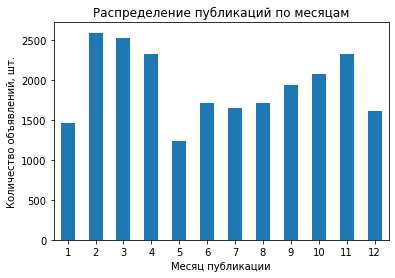

In [72]:
data_month = data.pivot_table(index='month_exposition', values='floor', aggfunc='count').reset_index()

ax = data_month.plot(
    x='month_exposition', 
    y='floor',
    xlabel='Месяц публикации',
    ylabel='Количество объявлений, шт.',
    kind='bar', 
    title='Распределение публикаций по месяцам',
    legend=False,
    rot=0
)

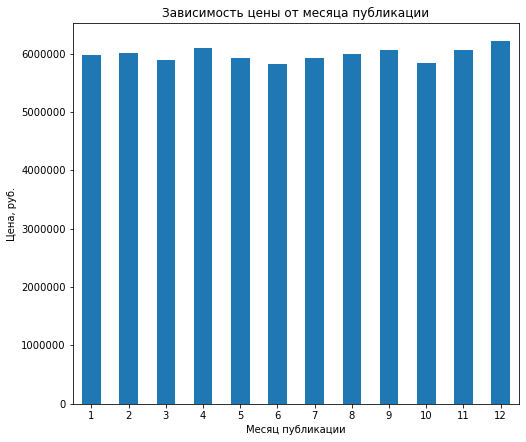

In [73]:
data_month_price = data.pivot_table(index='month_exposition', values='last_price', aggfunc='mean').reset_index()

ax = data_month_price.plot(
    x='month_exposition', 
    y='last_price',
    xlabel='Месяц публикации',
    ylabel='Цена, руб.',
    kind='bar', 
    title='Зависимость цены от месяца публикации', 
    figsize=(8,7),
    legend=False,
    rot=0
)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Самые активные месяцы, судя по выборке - февраль и март. Меньше всего объявлений в мае. Апрель, сентябрь и декабрь - месяцы, когда цены немного растут. Самые низкие цены в октябре.

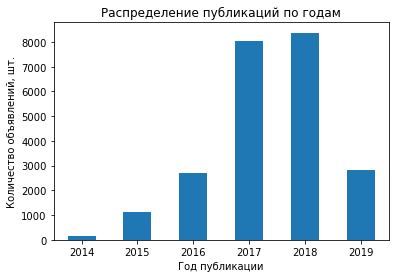

In [74]:
data_year = data.pivot_table(index='year_exposition', values='floor', aggfunc='count').reset_index()

ax = data_year.plot(
    x='year_exposition', 
    y='floor', 
    kind='bar',
    xlabel='Год публикации',
    ylabel='Количество объявлений, шт.',
    title='Распределение публикаций по годам',
    legend=False,
    rot=0
)

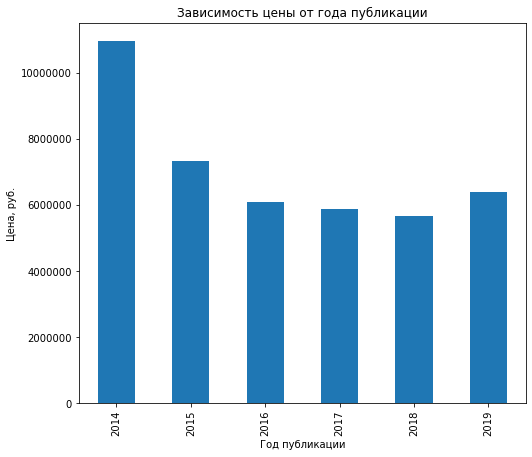

In [75]:
data_year_price = data.pivot_table(index='year_exposition', values='last_price', aggfunc='mean').reset_index()

ax = data_year_price.plot(
    x='year_exposition', 
    y='last_price', 
    xlabel='Год публикации',
    ylabel='Цена, руб.',
    kind='bar', 
    title='Зависимость цены от года публикации', 
    figsize=(8,7),
    legend=False
)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

В нашей выборке больше всего объявлений за 2017 и 2018 годы. Медианная цена падает с 2014 года по 2018. Можно предположить, что в 2015 году стало появляться больше дешевых новостроек в спальных районах, и медианная цена пошла вниз, а до этого времени доля дорогих квартир в историческом центре была выше.

Изучим, какие факторы влияют на стоимость объекта.

**Площадь**

0.6578424191456397

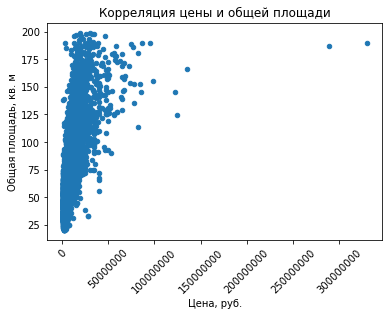

In [76]:
display(data['last_price'].corr(data['total_area']))
ax = data.plot(
    x='last_price', 
    y='total_area', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Общая площадь, кв. м',
    title='Корреляция цены и общей площади',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Размер квартиры значительным образом влияет на цену, корреляция близка к прямой. В случае с кваартирами более 100 метров мы видим больше выбросов, что еще раз подчеркиваает наличие уникальных объектов с другим ценообразованием.

**Жилая площадь**

0.5528913367806593

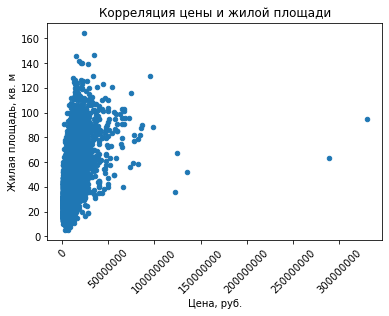

In [77]:
display(data['last_price'].corr(data['living_area']))

ax = data.plot(
    x='last_price', 
    y='living_area', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Жилая площадь, кв. м',
    title='Корреляция цены и жилой площади',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Размер жилой площади важен. Корреляция заметная.

**Площадь кухни**

0.5380280124017571

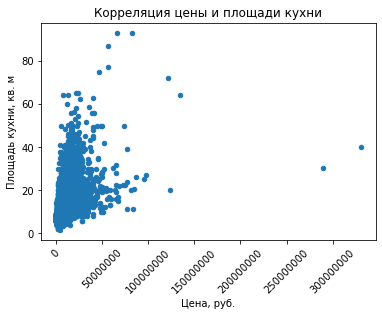

In [78]:
display(data['last_price'].corr(data['kitchen_area']))

ax = data.plot(
    x='last_price', 
    y='kitchen_area', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Площадь кухни, кв. м',
    title='Корреляция цены и площади кухни',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Размер кухни чуть меньше коррелирует с ценой, чем размер жилой площади, но также является заметным фактором. Оба показателя входят в общую площадь, которая является основным фактором, который влияет на цену квартиры.

**Количество комнат**

0.3671864020148288

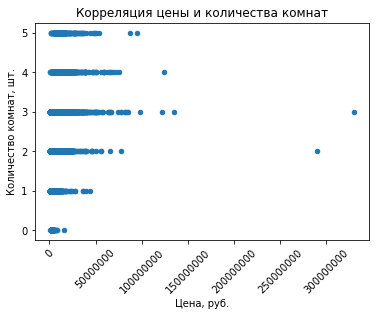

In [79]:
display(data['last_price'].corr(data['rooms']))

ax = data.plot(
    x='last_price', 
    y='rooms', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Количество комнат, шт.',
    title='Корреляция цены и количества комнат',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Количество комнат влияет на цену меньше, чем площадь. Обычно, тем больше площадь квартиры, тем больше комнат. Вот и цена выше.

**Высота потолков**

0.3411925898676173

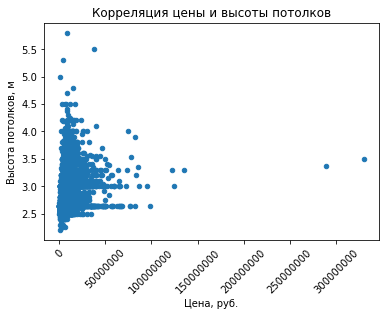

In [80]:
display(data['last_price'].corr(data['ceiling_height']))

ax = data.plot(
    x='last_price', 
    y='ceiling_height', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Высота потолков, м',
    title='Корреляция цены и высоты потолков',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Высота потолков сильно коррелирует с ценой. Высокие потолки - показатель жилья бизнес-класса или исторической застройки. Все себе такое хотят.

**Этаж**

0.046920224695000075

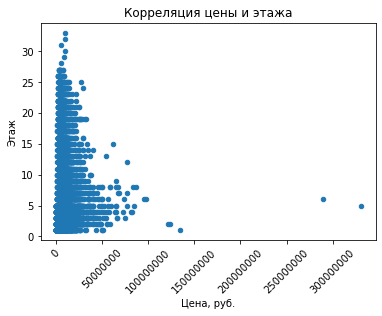

In [81]:
display(data['last_price'].corr(data['floor']))

ax = data.plot(
    x='last_price', 
    y='floor', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Этаж',
    title='Корреляция цены и этажа',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Этаж мало влияет на цену, но на графике видно, что чем выше этаж, тем больше минимальная цена. Или высокие дома в среднем более новые, или люди вссе-таки готовы приплатить, чтобы жить повыше (но немного)

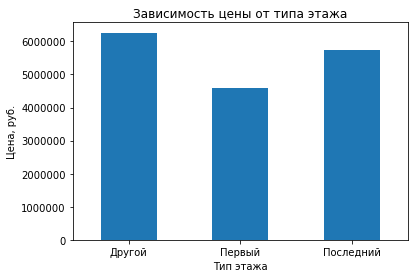

In [82]:
data_floor_type = data.pivot_table(index='floor_type', values='last_price', aggfunc='mean').reset_index()

ax = data_floor_type.plot(
    x='floor_type', 
    y='last_price', 
    kind='bar',
    xlabel='Тип этажа',
    ylabel='Цена, руб.',
    title='Зависимость цены от типа этажа',
    rot=0,
    legend=False
)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Если сравнивать стоимость квартир, на первых и последних этажах, то она несколько ниже, чем на других этажах. Дешевле всех - первые этажи.

**Количество балконов**

0.020757902790680408

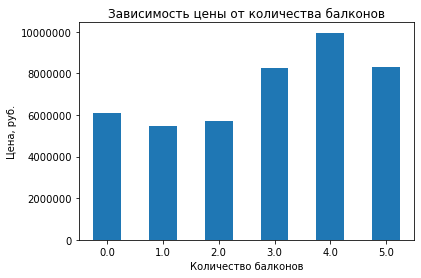

In [83]:
display(data['last_price'].corr(data['balcony']))
data_balcony = data.pivot_table(index='balcony', values='last_price', aggfunc='mean').reset_index()

ax = data_balcony.plot(
    x='balcony', 
    y='last_price', 
    kind='bar',
    xlabel='Количество балконов',
    ylabel='Цена, руб.',
    title='Зависимость цены от количества балконов',
    rot=0,
    legend=False
)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Наличие балконов - не самый важный элемент ценообразования. Но квартиры, где 3 балкона и больше заметно дороже.

**Близость аэропорта**

Для анализа зависимости цены от близости аэропорта возьмем только строки, где заполнено поле airports_nearest

In [84]:
data_airport = data[~data['airports_nearest'].isna()]

-0.027348720023154034

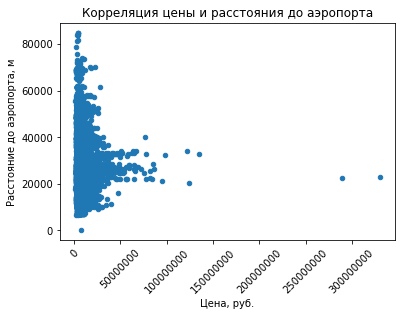

In [85]:
display(data_airport['last_price'].corr(data_airport['airports_nearest']))
ax = data_airport.plot(
    x='last_price', 
    y='airports_nearest', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Расстояние до аэропорта, м',
    title='Корреляция цены и расстояния до аэропорта',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Я думаю, тут мы имеем дело с двумя разнонаправленными факторами. С одной стороны, неплохо жить недалеко от аэропорта и, собираясь в отпуск, вызывать такси не за 5 часов до вылета. С другой стороны, близко к аэропорту - значит далеко от центра города, а для покупателей второй фактор значительно важнее. Поэтому корреляция с ценой отрицательная.

**Близость парка**

Влияние парков будем оценивать по усеченной выборке аналогично с аэропортами

In [86]:
data_parks = data[~data['parks_nearest'].isna()]

-0.007260454947085726

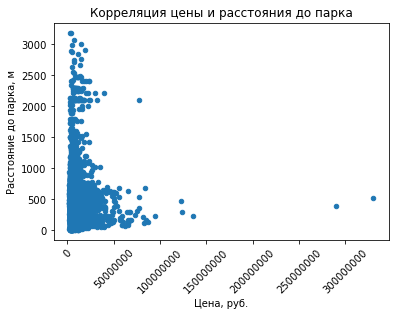

In [87]:
display(data_parks['last_price'].corr(data_parks['parks_nearest']))

ax = data_parks.plot(
    x='last_price', 
    y='parks_nearest', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Расстояние до парка, м',
    title='Корреляция цены и расстояния до парка',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Удивительный вывод! Близость парков отрицательно влияет на цену! Хоть влияние и незначительное, практически нулевое. Я думаю причина та же, что и аэропорты - влияние парков перекрывает влияние на близость к центру города. В центре больших парков нет, вот и получается, что там, где парки, квартиры дешевле.

**Близость пруда**

In [88]:
data_pounds = data[~data['ponds_nearest'].isna()]

-0.10246243592375

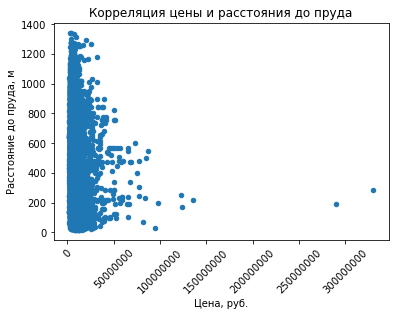

In [89]:
display(data_pounds['last_price'].corr(data['ponds_nearest']))

ax = data_pounds.plot(
    x='last_price', 
    y='ponds_nearest', 
    kind='scatter',
    xlabel='Цена, руб.',
    ylabel='Расстояние до пруда, м',
    title='Корреляция цены и расстояния до пруда',
    rot=45
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Пруды тоже не привлекают покупателей квартир. Все хотят жить поближе к центру, а есть рядом пруд или нет - дело десятое.

**Топ-10 населенных пунктов по количеству объявлений**

In [90]:
data_locality_price = (
    data
    .pivot_table(index='locality_name', values='one_m_price', aggfunc='mean')
    .reset_index()
    .sort_values(by='one_m_price', ascending=False)
)
data_locality_price_max = data_locality_price.iloc[0]
data_locality_price_min = data_locality_price.iloc[303]
print(f'Самая высокая ср. стоимость кв. м в нас. пункте {data_locality_price_max.locality_name}: {data_locality_price_max.one_m_price:.2f} руб.')
print(f'Самая низкая ср. стоимость кв. м в нас. пункте {data_locality_price_min.locality_name}: {data_locality_price_min.one_m_price:.2f} руб.')

Самая высокая ср. стоимость кв. м в нас. пункте Зеленогорск: 115122.80 руб.
Самая низкая ср. стоимость кв. м в нас. пункте Старополье: 11206.22 руб.


In [91]:
data_top_10 = (
    data
    .pivot_table(index='locality_name', values='one_m_price', aggfunc={'count','mean'})
    .reset_index()
    .sort_values(by='count', ascending=False)
    .head(10)
    .rename(columns={'mean': 'rub per sq m'})
    .style.format({'rub per sq m' : '{:8.0f}'})
)
data_top_10

,locality_name,count,rub per sq m
222,Санкт-Петербург,15346,113475
145,Мурино,585,86039
105,Кудрово,468,95273
295,Шушары,438,78529
34,Всеволожск,396,68748
201,Пушкин,362,103168
88,Колпино,337,75333
169,Парголово,326,90332
42,Гатчина,307,68746
35,Выборг,235,58238


Самое больше количество предложений, ожидаемо, в Петербурге. Самая большая средняя цена в курортном городе Зеленогорск, а самая низкая - в деревне Сарополье.

**Зависимость цены кв. м от удаленности от центра города**

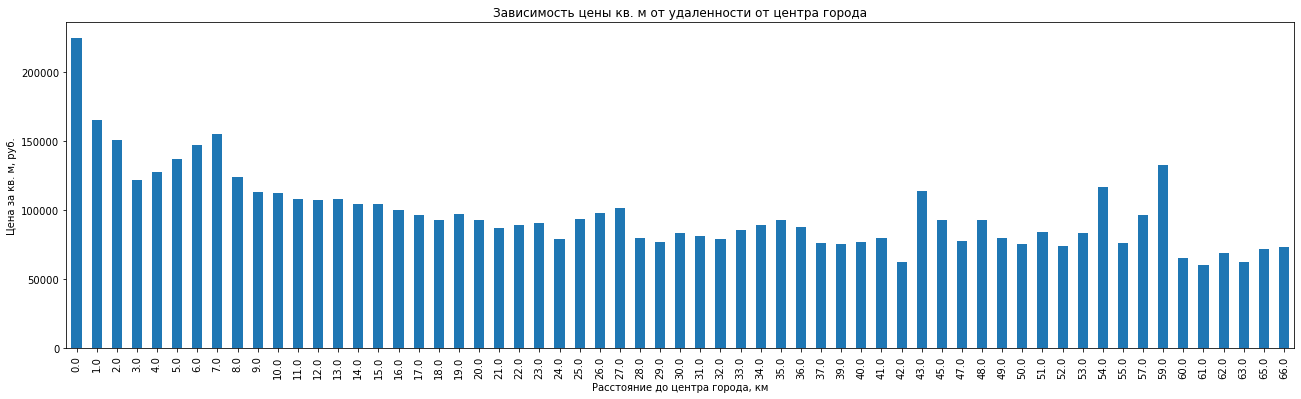

In [92]:
data_km_price = (
    data
    .pivot_table(index='city_centers_nearest_km', values='one_m_price', aggfunc='mean')
    .reset_index()
    .sort_values(by='city_centers_nearest_km')
    .plot(
        x='city_centers_nearest_km', 
        y='one_m_price', kind='bar', 
        title='Зависимость цены кв. м от удаленности от центра города', 
        xlabel='Расстояние до центра города, км',
        ylabel='Цена за кв. м, руб.',
        figsize=(22,6),
        legend=False
    )
)

Зависимость цены от удаленности от центра города нелинейна. Самые дорогие предложения, ожидаемо, находятся в самом центре, но квартиры в 3 км оказались дешевле, чем те, что находятся в 7 км. Дальше есть пики в 43, 54 и 59 км от центра. Очевидно, на цену влияет не только расположение относительно исторического центра, но и другие факторы (район, транспортная доступность, тип дома). Можно также предположить, что цены квартир, находящиеся дальше 20 км от центра, меньше зависят от удаленности, и на них начинают влиять другие факторы, которые мы не изучили в данном исследовании (район, транспортная доступность, тип дома).

Проведенный анализ показывает нам как очевидные закономерности, вроде сильной корреляции цены квартиры и ее площади и удаленности от центра, а также неожиданные открытия, в частности, тот факт, что цена за квадратный метр в Санкт-Петербурге после 2014 года падала до 2019 или что покупателям квартиры на самом деле не так уж и важно, есть ли рядом паркт или пруд. 

## Общий вывод

Факторы, которые больше всего влияют на стоимость квартиры:
- Общая площадь и ее сотавляющие жилая площадь и площадь кухни.
- Удаленность от центра города. После определенного расстояния ок. 20 км этот фактор становится менее значимым
- Количество комнат
- Высота потолков
- Тип этажа (не первый и не последний)

Факторы, которые влияют на цену незначительно:
- Количество балконов
- Близость парка
- Близость аэропорта
- Близость пруда
- Этаж (если это не первый и не последний)
<br>
<br>Типичное предложение о продажи квартиры - 1-комнатная квартира около 30 кв. м и 2-комнатная около 50 кв. м.
<br>Стоимость большой части предложенных квартир - до 8 млн. рублей
<br>Средняя высота потолков - 2.65, но есть достаточно предложений и выше 3 м
<br>Люди готовы заплатить за квартиру на последнем этаже больше, чем на первом.
<br>Объявления о продаже чаще публикуются в будние дни. В разбивке по месяцам самые популярные февраль и март. Меньше всего объявлений в мае.
<br>Объявление о продаже в среднем висит около полугода. Есть квартиры, которые продаются за 1 день. Быстрой считается продажа до 45 дней, долгой - более 230 дней.
<br> 
<br> Города, с самым большим количеством предложений, помимо Санкт-Петербурга: Мурино, Кудрово, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, Выборг
<br>
<br> Самая высокая медианная цена за кв. м не в Санкт-Петербурге, а в курортном Зеленогорске.
<br> Самая низкая цена - в деревне Старополье
<br> Медианная цена квартиры падает после 2014 года. Это можно объяснить большим количеством дешевых предложений и увеличением их доли в выборке.
<br>